In [7]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from diffusers import UNet2DModel, DDIMScheduler, DDPMScheduler, LMSDiscreteScheduler
import torch
import torch.nn as nn
import torch.optim as optim
import csv

d:\NCKH\Blockchain_contest\Federated_Learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df=pd.read_csv("IoTDIAD.csv")
df

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,192.168.137.66-192.168.137.174-41082-80-6,192.168.137.66,41082.0,192.168.137.174,80.0,6.0,09/08/2022 11:27:38 AM,1527173.0,16.0,1.0,...,20.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,DoS
1,192.168.137.66-192.168.137.254-55598-34287-6,192.168.137.66,55598.0,192.168.137.254,34287.0,6.0,09/08/2022 11:56:16 AM,9912071.0,7.0,2.0,...,32.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,DoS
2,192.168.137.174-192.168.137.66-80-47994-6,192.168.137.174,80.0,192.168.137.66,47994.0,6.0,09/08/2022 11:29:10 AM,0.0,2.0,0.0,...,20.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,DoS
3,192.168.137.66-192.168.137.254-59336-8009-6,192.168.137.66,59336.0,192.168.137.254,8009.0,6.0,09/08/2022 11:50:16 AM,349868.0,1.0,1.0,...,40.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,DoS
4,192.168.137.66-192.168.137.254-55662-8009-6,192.168.137.66,55662.0,192.168.137.254,8009.0,6.0,09/08/2022 11:49:16 AM,215841.0,1.0,1.0,...,40.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,DoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33613,192.168.137.79-255.255.255.255-49154-6667-17,192.168.137.79,49154.0,255.255.255.255,6667.0,17.0,07/10/2022 03:06:15 PM,119995219.0,25.0,0.0,...,8.0,1.165906e+07,6.061784e+06,19997148.0,4965723.0,5006391.25,13272.949739,5038906.0,5000281.0,BenignTraffic
33614,157.249.81.141-192.168.137.41-80-51746-6,157.249.81.141,80.0,192.168.137.41,51746.0,6.0,07/10/2022 06:00:51 PM,126325.0,4.0,0.0,...,32.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,BenignTraffic
33615,192.168.137.186-192.168.137.1-42090-53-17,192.168.137.186,42090.0,192.168.137.1,53.0,17.0,07/10/2022 05:16:07 PM,85450.0,2.0,2.0,...,8.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,BenignTraffic
33616,205.174.165.69-192.168.137.187-24421-63908-17,205.174.165.69,24421.0,192.168.137.187,63908.0,17.0,07/10/2022 09:11:08 PM,1115118.0,7.0,0.0,...,8.0,0.000000e+00,0.000000e+00,0.0,0.0,0.00,0.000000,0.0,0.0,BenignTraffic


In [9]:
df['label'].unique()

array(['DoS', 'Mirai', 'Recon', 'Spoofing', 'Web-based', 'Brute_Force',
       'DDoS', 'BenignTraffic'], dtype=object)

Shape: (33618, 84)


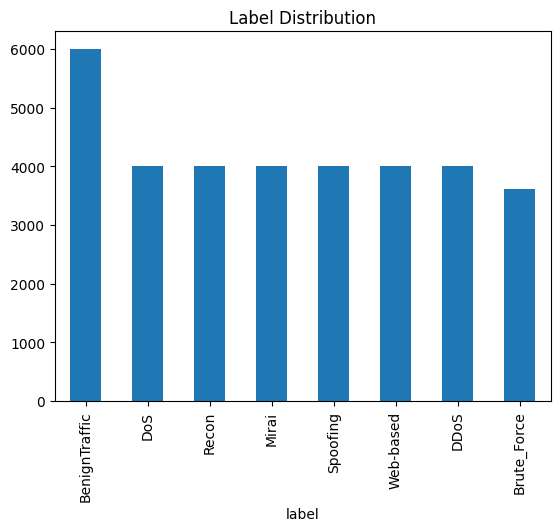

In [10]:
print('Shape:', df.shape)
df.head()
df.isnull().sum()  # Kiểm tra missing values
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df["Year"] = df["Timestamp"].dt.year
df["Month"] = df["Timestamp"].dt.month
df["Day"] = df["Timestamp"].dt.day
df["Hour"] = df["Timestamp"].dt.hour
df["Minute"] = df["Timestamp"].dt.minute
df["Second"] = df["Timestamp"].dt.second

df.drop(columns=["Timestamp"], inplace=True)

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

df["Flow ID"] = df["Flow ID"].astype("category").cat.codes
df["Src IP"] = df["Src IP"].astype("category").cat.codes
df["Dst IP"] = df["Dst IP"].astype("category").cat.codes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33618 entries, 0 to 33617
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Flow ID                     33618 non-null  int16  
 1   Src IP                      33618 non-null  int16  
 2   Src Port                    33618 non-null  float64
 3   Dst IP                      33618 non-null  int16  
 4   Dst Port                    33618 non-null  float64
 5   Protocol                    33618 non-null  float64
 6   Flow Duration               33618 non-null  float64
 7   Total Fwd Packet            33618 non-null  float64
 8   Total Bwd packets           33618 non-null  float64
 9   Total Length of Fwd Packet  33618 non-null  float64
 10  Total Length of Bwd Packet  33618 non-null  float64
 11  Fwd Packet Length Max       33618 non-null  float64
 12  Fwd Packet Length Min       33618 non-null  float64
 13  Fwd Packet Length Mean      336

In [13]:
# Load dataset (assuming 'df' is already loaded)
y = df['label'].values  # Convert to numpy array
X = df.drop(columns=['label']).values  # Convert to numpy array

# Handle NaN and infinite values
X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)
X = np.clip(X, -1e10, 1e10)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modify the get_diffusion_model function to include the new models
def get_diffusion_model(model_type='UNet'):
    if model_type == 'UNet':
        return UNet2DModel(sample_size=32, in_channels=1, out_channels=1, layers_per_block=2,
                           block_out_channels=(64, 128, 256),
                           down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
                           up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
                           norm_num_groups=8)
    elif model_type == 'DDIM':
        return DDIMScheduler(num_train_timesteps=1000, beta_start=0.00085, beta_end=0.012, beta_schedule="linear")
    elif model_type == 'DDPM':
        return DDPMScheduler(num_train_timesteps=1000, beta_start=0.00085, beta_end=0.012, beta_schedule="linear")
    elif model_type == 'SBGM':
        # Placeholder for Score-Based Generative Models
        return "Score-Based Generative Model - Placeholder"
    elif model_type == 'LDM':
        # Placeholder for Latent Diffusion Models (LDM)
        return "Latent Diffusion Model - Placeholder"
    elif model_type == 'ConditionalDiffusion':
        # Placeholder for Conditional Diffusion Models
        return "Conditional Diffusion Model - Placeholder"
    elif model_type == 'EBM':
        # Placeholder for Score-Matching Energy-Based Models (EBMs)
        return "Score-Matching Energy-Based Model - Placeholder"
    elif model_type == 'DiffAutoencoder':
        # Placeholder for Diffusion-based Autoencoders
        return "Diffusion-based Autoencoder - Placeholder"
    elif model_type == 'VariationalDiffusion':
        # Placeholder for Variational Diffusion Models
        return "Variational Diffusion Model - Placeholder"
    else:
        raise ValueError("Invalid diffusion model type specified.")

# Function to generate synthetic samples using Diffusion models
def generate_samples_with_diffusion(X_train, y_train, model_type='UNet', threshold=4800):
    print(f"\n Number of samples before augmentation: {X_train.shape[0]}\n")

    # Print sample count for each class before augmentation
    class_counts_before = Counter(y_train)
    for class_label, count in class_counts_before.items():
        print(f"   ➤ Class {class_label}: {count} samples before augmentation")

    model = get_diffusion_model(model_type)  # Load the selected diffusion model
    X_augmented = []
    y_augmented = []

    for class_label, count in class_counts_before.items():
        if count < threshold:
            samples_needed = threshold - count  # Calculate how many samples are needed
            noise = torch.randn((samples_needed, X_train.shape[1]))  # Generate synthetic noise
            generated_samples = noise.numpy()  # Replace with actual model inference
            X_augmented.extend(generated_samples)
            y_augmented.extend([class_label] * samples_needed)

    # Combine original and generated samples
    X_train_augmented = np.vstack([X_train, np.array(X_augmented)])
    y_train_augmented = np.hstack([y_train, np.array(y_augmented)])

    print(f"Number of samples after augmentation: {X_train_augmented.shape[0]}")

    # Print sample count for each class after augmentation
    class_counts_after = Counter(y_train_augmented)
    for class_label, count in class_counts_after.items():
        print(f"  Class {class_label}: {count} samples after augmentation")

    return X_train_augmented, y_train_augmented, class_counts_before, class_counts_after
# Feature selection using ANOVA (f_classif)
def feature_selection(X_train, X_test, y_train, k=30):
    # Using ANOVA to select the best k features
    selector = SelectKBest(f_classif, k=min(k, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)  # Apply feature selection to the training data
    X_test_selected = selector.transform(X_test)  # Apply feature selection to the test data
    selected_columns = [i for i, support in enumerate(selector.get_support()) if support]  # Get the selected columns
    print(f"Selected features (columns): {selected_columns}")  # Print the selected feature columns
    return X_train_selected, X_test_selected, selected_columns


In [14]:
# Define RNN model
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out
def train_birnn(X_train, y_train, X_test, y_test, input_size, hidden_size, num_classes, num_epochs=2000):
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(y_test, dtype=torch.long)

    model = BiRNN(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)

        precision = precision_score(y_test, predicted, average=None, zero_division=0)
        recall = recall_score(y_test, predicted, average=None, zero_division=0)
        f1 = f1_score(y_test, predicted, average=None, zero_division=0)

    return accuracy, precision, recall, f1, num_epochs

In [15]:
import torch
print(torch.__version__)
print(torch.version.cuda)  # Nếu ra None → bản CPU
print(torch.backends.cudnn.enabled)


2.7.1+cu118
11.8
True


In [16]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0))


CUDA available: True
Device count: 1
Device name: NVIDIA GeForce RTX 4050 Laptop GPU


Using device: cuda

 Number of samples before augmentation: 26894

   ➤ Class 0: 4800 samples before augmentation
   ➤ Class 6: 3200 samples before augmentation
   ➤ Class 4: 3200 samples before augmentation
   ➤ Class 1: 2894 samples before augmentation
   ➤ Class 5: 3200 samples before augmentation
   ➤ Class 3: 3200 samples before augmentation
   ➤ Class 2: 3200 samples before augmentation
   ➤ Class 7: 3200 samples before augmentation
Number of samples after augmentation: 38400
  Class 0: 4800 samples after augmentation
  Class 6: 4800 samples after augmentation
  Class 4: 4800 samples after augmentation
  Class 1: 4800 samples after augmentation
  Class 5: 4800 samples after augmentation
  Class 3: 4800 samples after augmentation
  Class 2: 4800 samples after augmentation
  Class 7: 4800 samples after augmentation
Selected features (columns): [0, 1, 2, 3, 4, 5, 12, 13, 21, 23, 24, 26, 28, 29, 43, 45, 48, 50, 57, 58, 70, 73, 78, 80, 82, 83, 84, 85, 86, 87]
Epoch [1/2000] | Train Ac

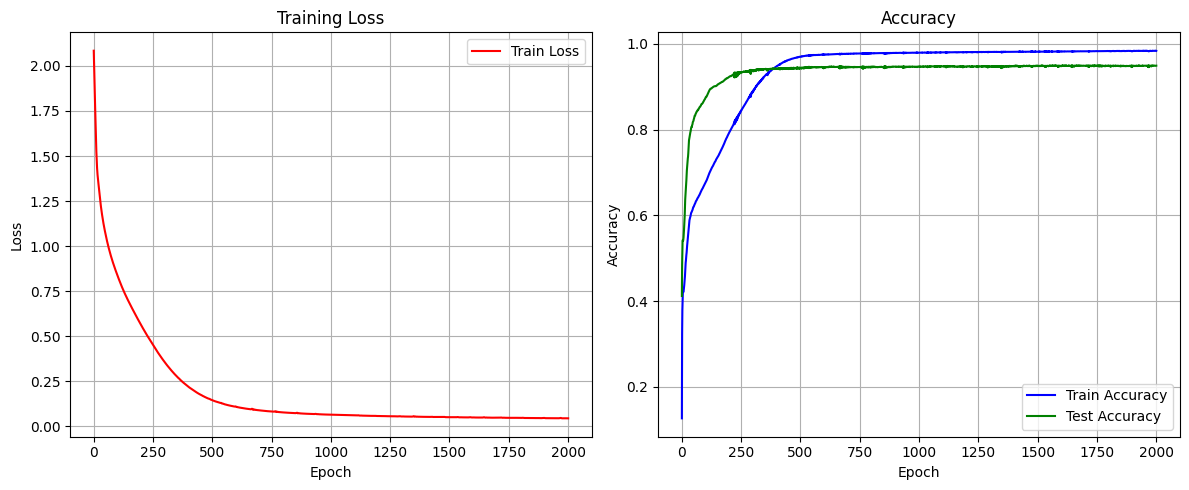

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Thiết bị: GPU nếu có ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Mô hình BiRNN ---
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        

    def forward(self, x):
        out, _ = self.lstm(x)         # out shape: (batch, seq_len, hidden*2)
        out = self.fc(out[:, -1, :])
        return out

# === Chọn 1 diffusion model cụ thể ===
model_type = 'DiffAutoencoder'
X_train_aug, y_train_aug, _, _ = generate_samples_with_diffusion(X_train_scaled, y_train, model_type)

# === Feature selection ===
X_train_selected, X_test_selected, selected_columns = feature_selection(X_train_aug, X_test_scaled, y_train_aug)

# === Chuyển sang tensor và đưa lên device ===
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train_aug, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# === Khởi tạo model ===
input_size = X_train_selected.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train_aug))
model = BiLSTM(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# === Huấn luyện ===
num_epochs = 2000
train_accuracies = []
test_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    _, predicted_train = torch.max(outputs, 1)
    train_acc = (predicted_train == y_train_tensor).float().mean().item()
    train_accuracies.append(train_acc)

    # Đánh giá test
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        test_acc = (predicted_test == y_test_tensor).float().mean().item()
        test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}% | Loss: {loss.item():.4f}")

# === Evaluation trên test set ===
print("\n📊 Classification Report:")
print(classification_report(y_test_tensor.cpu().numpy(), predicted_test.cpu().numpy(), zero_division=0))

# === Plot Loss & Accuracy ===
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# --- Loss plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# --- Accuracy plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



 Number of samples before augmentation: 26894

   ➤ Class 0: 4800 samples before augmentation
   ➤ Class 6: 3200 samples before augmentation
   ➤ Class 4: 3200 samples before augmentation
   ➤ Class 1: 2894 samples before augmentation
   ➤ Class 5: 3200 samples before augmentation
   ➤ Class 3: 3200 samples before augmentation
   ➤ Class 2: 3200 samples before augmentation
   ➤ Class 7: 3200 samples before augmentation
Number of samples after augmentation: 38400
  Class 0: 4800 samples after augmentation
  Class 6: 4800 samples after augmentation
  Class 4: 4800 samples after augmentation
  Class 1: 4800 samples after augmentation
  Class 5: 4800 samples after augmentation
  Class 3: 4800 samples after augmentation
  Class 2: 4800 samples after augmentation
  Class 7: 4800 samples after augmentation
Selected features (columns): [0, 1, 3, 4, 5, 11, 12, 13, 21, 23, 24, 26, 28, 29, 43, 45, 48, 50, 57, 58, 70, 73, 78, 80, 82, 83, 84, 85, 86, 87]
Epoch [1/2000] | Train Acc: 10.16% | Test A

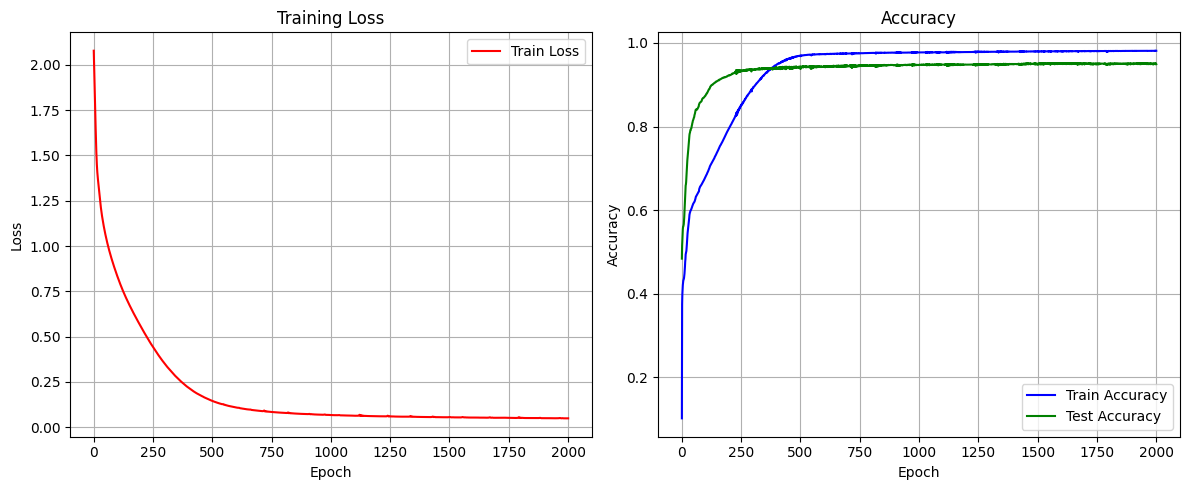

In [33]:
# === Chọn 1 diffusion model cụ thể ===
model_type = 'VariationalDiffusion'
X_train_aug, y_train_aug, _, _ = generate_samples_with_diffusion(X_train_scaled, y_train, model_type)

# === Feature selection ===
X_train_selected, X_test_selected, selected_columns = feature_selection(X_train_aug, X_test_scaled, y_train_aug)

# === Chuyển sang tensor và đưa lên device ===
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train_aug, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# === Khởi tạo model ===
input_size = X_train_selected.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train_aug))
model = BiLSTM(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# === Huấn luyện ===
num_epochs = 2000
train_accuracies = []
test_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    _, predicted_train = torch.max(outputs, 1)
    train_acc = (predicted_train == y_train_tensor).float().mean().item()
    train_accuracies.append(train_acc)

    # Đánh giá test
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        test_acc = (predicted_test == y_test_tensor).float().mean().item()
        test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}% | Loss: {loss.item():.4f}")

# === Evaluation trên test set ===
print("\n📊 Classification Report:")
print(classification_report(y_test_tensor.cpu().numpy(), predicted_test.cpu().numpy(), zero_division=0))

# === Plot Loss & Accuracy ===
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# --- Loss plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# --- Accuracy plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
# Lấy danh sách label đã mã hóa (sau khi LabelEncoder)
unique_labels = sorted(df['label'].unique())
print("Các label:", unique_labels)

# Chia 4 label đầu cho foundation, 4 label sau cho federated learning
foundation_labels = unique_labels[:4]
federated_labels = unique_labels[4:]

print("Foundation labels:", foundation_labels)
print("Federated labels:", federated_labels)

Các label: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Foundation labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Federated labels: [np.int64(4), np.int64(5), np.int64(6), np.int64(7)]


In [36]:
# Lọc dữ liệu cho foundation model (chỉ chứa 4 label đầu)
df_foundation = df[df['label'].isin(foundation_labels)].reset_index(drop=True)
print("Shape foundation:", df_foundation.shape)
print(df_foundation['label'].value_counts())

Shape foundation: (17618, 89)
label
0    6000
3    4000
2    4000
1    3618
Name: count, dtype: int64


In [37]:
# Tạo 4 tập federated, mỗi tập chỉ chứa 1 label
federated_datasets = {}
for label in federated_labels:
    federated_datasets[label] = df[df['label'] == label].reset_index(drop=True)
    print(f"Federated client label {label}: shape = {federated_datasets[label].shape}")

Federated client label 4: shape = (4000, 89)
Federated client label 5: shape = (4000, 89)
Federated client label 6: shape = (4000, 89)
Federated client label 7: shape = (4000, 89)


In [ ]:
# lưu ra file CSV 
df_foundation.to_csv("foundation_data.csv", index=False)
for label, df_client in federated_datasets.items():
    df_client.to_csv(f"federated_client_label_{label}.csv", index=False)

## 1. Tiền xử lý & huấn luyện Foundation Model
Các bước: tách dữ liệu, chia train/test, chuẩn hóa, chọn đặc trưng, (tùy chọn) augmentation, huấn luyện mô hình.

d:\NCKH\Blockchain_contest\Federated_Learning\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [36 37 38 53 60 61 62] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\NCKH\Blockchain_contest\Federated_Learning\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


d:\NCKH\Blockchain_contest\Federated_Learning\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [36 37 38 53 60 61 62] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\NCKH\Blockchain_contest\Federated_Learning\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected features (columns): [0, 1, 2, 4, 5, 12, 13, 21, 23, 24, 26, 28, 29, 43, 45, 48, 50, 57, 58, 70, 73, 78, 80, 81, 82, 83, 84, 85, 86, 87]

 Number of samples before augmentation: 14094

   ➤ Class 1: 2894 samples before augmentation
   ➤ Class 0: 4800 samples before augmentation
   ➤ Class 3: 3200 samples before augmentation
   ➤ Class 2: 3200 samples before augmentation
Number of samples after augmentation: 19200
  Class 1: 4800 samples after augmentation
  Class 0: 4800 samples after augmentation
  Class 3: 4800 samples after augmentation
  Class 2: 4800 samples after augmentation
Epoch [1/400] | Train Acc: 23.09% | Test Acc: 73.50% | Loss: 1.3868
Epoch [1/400] | Train Acc: 23.09% | Test Acc: 73.50% | Loss: 1.3868
Epoch [10/400] | Train Acc: 66.62% | Test Acc: 82.01% | Loss: 0.8780
Epoch [10/400] | Train Acc: 66.62% | Test Acc: 82.01% | Loss: 0.8780
Epoch [20/400] | Train Acc: 71.01% | Test Acc: 87.88% | Loss: 0.6954
Epoch [20/400] | Train Acc: 71.01% | Test Acc: 87.88% | Loss

d:\NCKH\Blockchain_contest\Federated_Learning\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [36 37 38 53 60 61 62] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
d:\NCKH\Blockchain_contest\Federated_Learning\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected features (columns): [0, 1, 2, 4, 5, 12, 13, 21, 23, 24, 26, 28, 29, 43, 45, 48, 50, 57, 58, 70, 73, 78, 80, 81, 82, 83, 84, 85, 86, 87]

 Number of samples before augmentation: 14094

   ➤ Class 1: 2894 samples before augmentation
   ➤ Class 0: 4800 samples before augmentation
   ➤ Class 3: 3200 samples before augmentation
   ➤ Class 2: 3200 samples before augmentation
Number of samples after augmentation: 19200
  Class 1: 4800 samples after augmentation
  Class 0: 4800 samples after augmentation
  Class 3: 4800 samples after augmentation
  Class 2: 4800 samples after augmentation
Epoch [1/400] | Train Acc: 23.09% | Test Acc: 73.50% | Loss: 1.3868
Epoch [1/400] | Train Acc: 23.09% | Test Acc: 73.50% | Loss: 1.3868
Epoch [10/400] | Train Acc: 66.62% | Test Acc: 82.01% | Loss: 0.8780
Epoch [10/400] | Train Acc: 66.62% | Test Acc: 82.01% | Loss: 0.8780
Epoch [20/400] | Train Acc: 71.01% | Test Acc: 87.88% | Loss: 0.6954
Epoch [20/400] | Train Acc: 71.01% | Test Acc: 87.88% | Loss

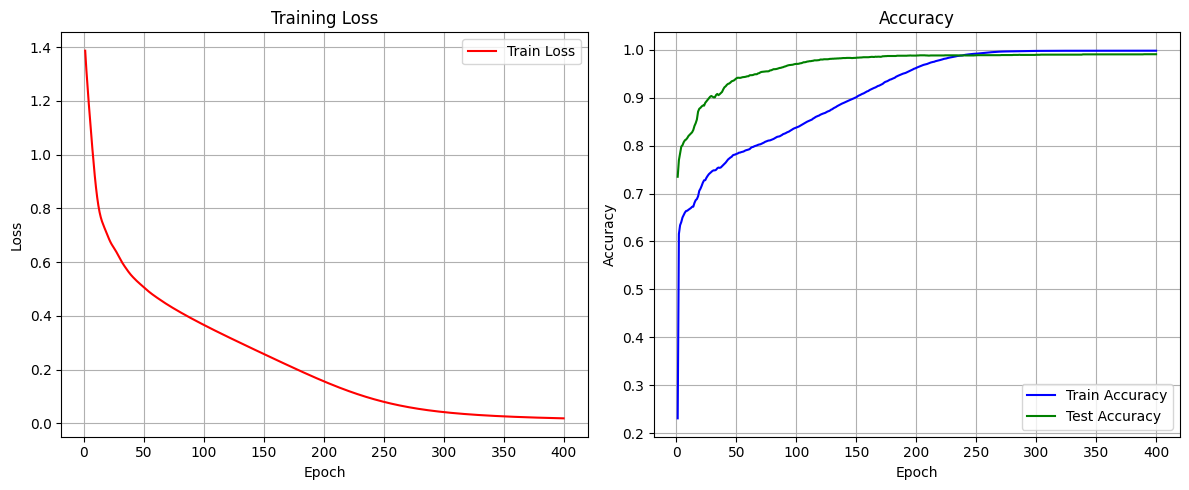

In [40]:
# --- Foundation Model Pipeline ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Tách dữ liệu và label
X_found = df_foundation.drop(columns=['label']).values
y_found = df_foundation['label'].values

# 2. Chia train/test
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_found, y_found, test_size=0.2, stratify=y_found, random_state=42)
# Xử lý NaN, inf, -inf và giới hạn giá trị
X_train_f = np.nan_to_num(X_train_f, nan=0, posinf=0, neginf=0)
X_test_f = np.nan_to_num(X_test_f, nan=0, posinf=0, neginf=0)
X_train_f = np.clip(X_train_f, -1e10, 1e10)
X_test_f = np.clip(X_test_f, -1e10, 1e10)

# 3. Chuẩn hóa dữ liệu
scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled = scaler_f.transform(X_test_f)

# 4. Chọn đặc trưng
X_train_f_selected, X_test_f_selected, selected_columns_f = feature_selection(X_train_f_scaled, X_test_f_scaled, y_train_f)

# 5. Augmentation
model_type = 'DDPM' 
X_train_f_aug, y_train_f_aug, _, _ = generate_samples_with_diffusion(X_train_f_selected, y_train_f, model_type)

# 6. Đưa dữ liệu sang tensor và lên device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_f_aug, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_f_selected, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train_f_aug, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_f, dtype=torch.long).to(device)

# 7. Định nghĩa mô hình BiLSTM
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train_f_selected.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train_f_aug))
model = BiLSTM(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 400
train_accuracies = []
test_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    _, predicted_train = torch.max(outputs, 1)
    train_acc = (predicted_train == y_train_tensor).float().mean().item()
    train_accuracies.append(train_acc)
    # Đánh giá test
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        test_acc = (predicted_test == y_test_tensor).float().mean().item()
        test_accuracies.append(test_acc)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}% | Loss: {loss.item():.4f}")

# Đánh giá cuối cùng trên test set
print("\nClassification Report (Foundation Model):")
print(classification_report(y_test_tensor.cpu().numpy(), predicted_test.cpu().numpy(), zero_division=0))

# Vẽ biểu đồ Loss & Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Tiền xử lý dữ liệu cho từng client federated
Các bước: lặp qua từng tập federated, tách dữ liệu/label, chia train/test, chuẩn hóa, chọn đặc trưng, lưu lại cho federated learning.

In [41]:
# --- Federated Clients Preprocessing Pipeline ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

client_data = {}
for label, df_client in federated_datasets.items():
    print(f"\n--- Client label {label} ---")
    X_client = df_client.drop(columns=['label']).values
    y_client = df_client['label'].values

    # Chia train/test
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_client, y_client, test_size=0.2, random_state=42)

    # Chuẩn hóa
    scaler_c = StandardScaler()
    X_train_c_scaled = scaler_c.fit_transform(X_train_c)
    X_test_c_scaled = scaler_c.transform(X_test_c)

    # Chọn đặc trưng
    X_train_c_selected, X_test_c_selected, selected_columns_c = feature_selection(X_train_c_scaled, X_test_c_scaled, y_train_c)

    # Augmentation
    model_type = 'DDPM'
    X_train_c_aug, y_train_c_aug, _, _ = generate_samples_with_diffusion(X_train_c_selected, y_train_c, model_type)
    

    # Lưu lại cho federated learning
    client_data[label] = {
        'X_train': X_train_c_selected,
        'y_train': y_train_c,
        'X_test': X_test_c_selected,
        'y_test': y_test_c,
        'X_train_aug': X_train_c_aug,
        'y_train_aug': y_train_c_aug,
        'selected_columns': selected_columns_c,
        'scaler': scaler_c
    }
    print(f"Train shape: {X_train_c_selected.shape}, Test shape: {X_test_c_selected.shape}")


--- Client label 4 ---



--- Client label 4 ---


ValueError: Input X contains infinity or a value too large for dtype('float64').